```{currentmodule} tskit
```

(sec_tskit_getting_started)=
# Getting started with {program}`tskit`

You've run some simulations or inference methods, and you now have a 
{class}`TreeSequence` object; what now? This tutorial is aimed 
users who are new to {program}`tskit` and would like to get some
basic tasks completed. We'll look at five fundamental things you might
need to do:
{ref}`process trees<sec_processing_trees>`,
{ref}`sites & mutations<sec_processing_sites_and_mutations>`, and
{ref}`genotypes<sec_processing_genotypes>`,
{ref}`compute statistics<sec_tskit_getting_started_compute_statistics>`, and
{ref}`save or export data<sec_tskit_getting_started_exporting_data>`.
Throughout, we'll also provide pointers to where you can learn more.

:::{note}
The examples in this
tutorial are all written using the {ref}`sec_python_api`, but it's also possible to
{ref}`use R <sec_tskit_r>`, or access the API in other languages, notably
{ref}`C<sec_c_api>` and [Rust](https://github.com/tskit-dev/tskit-rust).
:::

A number of different software programs can generate tree sequences. For the purposes
of this tutorial we'll use [{program}`msprime`](https://tskit.dev/msprime) to create
an example tree sequence representing the genetic genealogy of a 10Mb chromosome in
twenty diploid individuals. To make it a bit more interesting, we'll simulate the effects
of a {ref}`selective sweep<msprime:sec_ancestry_models_selective_sweeps>` in the middle
of the chromosome, then throw some neutral mutations onto the resulting tree sequence.

In [1]:
import msprime

pop_size=10_000
seq_length=10_000_000

sweep_model = msprime.SweepGenicSelection(
    position=seq_length/2, start_frequency=0.0001, end_frequency=0.9999, s=0.25, dt=1e-6)

ts = msprime.sim_ancestry(
    20,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=pop_size,
    sequence_length=seq_length,
    recombination_rate=1e-8,
    random_seed=1234,  # only needed for repeatabilty
    )
# Optionally add finite-site mutations to the ts using the Jukes & Cantor model, creating SNPs
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=4321)
ts

You can see that there are many thousands of trees in this tree sequence.

:::{note}
Since we simulated the ancestry of 20 *diploid* individuals, our tree sequence
contains 40 *sample nodes*, one for each genome.
:::

(sec_processing_trees)=

## Processing trees

Moving along a tree sequence usually involves iterating over all of its {class}`Tree`
objects. This common idiom underlies many tree sequence algorithms, including those
we'll encounter later in this tutorial for calculating 
{ref}`population genetic statistics<tskit:sec_stats>`.
To iterate over a tree sequence you can use
{meth}`TreeSequence.trees`.

In [2]:
for tree in ts.trees():
    print(f"Tree {tree.index} covers {tree.interval}")
    if tree.index >= 4:
        print("...")
        break
print(f"Tree {ts.last().index} covers {ts.last().interval}")

Tree 0 covers Interval(left=0.0, right=661.0)
Tree 1 covers Interval(left=661.0, right=3116.0)
Tree 2 covers Interval(left=3116.0, right=4451.0)
Tree 3 covers Interval(left=4451.0, right=4673.0)
Tree 4 covers Interval(left=4673.0, right=5020.0)
...
Tree 11166 covers Interval(left=9999635.0, right=10000000.0)


::::{margin}
:::{caution}
For efficiency, {meth}`~TreeSequence.trees` repeatedly returns the
same tree object, updating it internally to reflect the (usually small) changes
between adjacent trees. So take care to treat each tree within the ``for``
loop separately, avoiding e.g. references outside the loop. The following
produces a list of identical "null" trees:

```
# Don't do this!
list(ts.trees())
```

If you need separate instances of each tree (inefficient, and will
eat up your computer memory), use {meth}`~TreeSequence.aslist`.
:::
::::

In this code snippet, as well as the {meth}`~TreeSequence.trees` iterator, we've also
used {meth}`TreeSequence.last` to access the last tree directly; it may not surprise you
that there's a corresponding {meth}`TreeSequence.first` method to return the first tree.

Above, we stopped iterating after Tree 4 to limit the printed output, but iterating
forwards through trees in a tree sequence (or indeed backwards using the standard Python
{func}`~py:reversed` function) is efficient. That means it's quick, for example to check if all
the trees in a tree sequence have fully coalesced (which is to be expected in
reverse-time, coalescent simulations, but not always for tree sequences produced by
{ref}`forward simulation <sec_tskit_forward_simulations>`).

In [3]:
import time
elapsed = time.time()
for tree in ts.trees():
    if tree.has_multiple_roots:
        print("Tree {tree.index} has not coalesced")
        break
else:
    elapsed = time.time() - elapsed
    print(f"All {ts.num_trees} trees coalesced")
    print(f"Checked in {elapsed:.6g} secs")

All 11167 trees coalesced
Checked in 0.0243421 secs


Now that we know all trees have coalesced, we know that at each position in the genome
all the 40 sample nodes must have one most recent common ancestor (MRCA). Below, we
iterate over the trees, finding the IDs of the root (MRCA) node for each tree. The
time of this root node can be found via the {meth}`tskit.TreeSequence.node` method, which
returns a {class}`Node` object whose attributes include the node time:

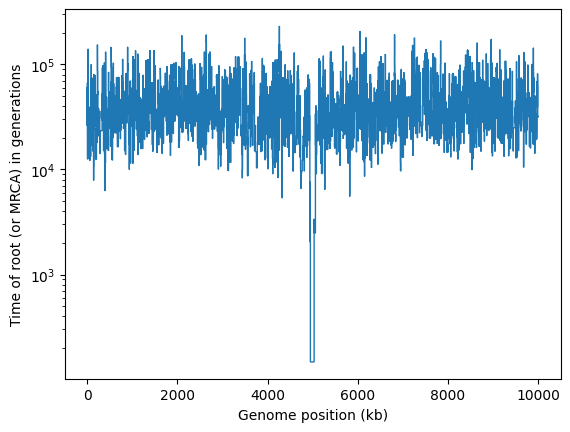

In [4]:
import matplotlib.pyplot as plt

kb = [0]  # Starting genomic position
mrca_time = []
for tree in ts.trees():
    kb.append(tree.interval.right/1000)  # convert to kb
    mrca = ts.node(tree.root)  # For msprime tree sequences, the root node is the MRCA
    mrca_time.append(mrca.time)
plt.stairs(mrca_time, kb, baseline=None)
plt.xlabel("Genome position (kb)")
plt.ylabel("Time of root (or MRCA) in generations")
plt.yscale("log")
plt.show()

It's obvious that there's something unusual about the trees in the middle of this
chromosome, where the selective sweep occurred. 

:::{margin} Comments needed
If you have a need for efficient random access to trees like this, please comment on
[this GitHub issue](https://github.com/tskit-dev/tskit/issues/684) to help us implement
a solution.
:::

Currently, it's not particularly efficient to pull out individual trees from the middle
of a tree sequence, but it *can* be done, via the
{meth}`TreeSequence.at` method. Here's the tree at location
$5\ 000\ 000$ --- the position of the sweep --- drawn using the 
{meth}`Tree.draw_svg` method.

Tree number 5382, which runs from position 4998293.0 to 5033047.0:


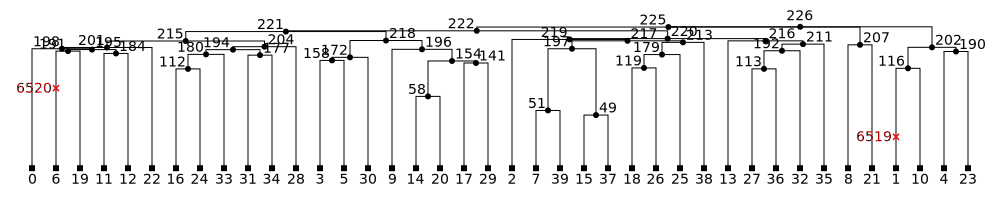

In [5]:
swept_tree = ts.at(5_000_000)  # or you can get e.g. the nth tree using ts.at_index(n)
intvl = swept_tree.interval
print(f"Tree number {swept_tree.index}, which runs from position {intvl.left} to {intvl.right}:")
# Draw it at a wide size, to make room for all 40 tips
swept_tree.draw_svg(size=(1000, 200))

:::{margin}
The {ref}`visualization tutorial <sec_tskit_viz>` gives more drawing possibilities
:::

This tree shows the classic signature of a recent expansion or selection event, with many
long terminal branches, resulting in an excess of singleton mutations.

:::{margin}
The {ref}`Simplification tutorial<sec_simplification>` details many other uses
for {meth}`~TreeSequence.simplify`.
:::

It can often be helpful to slim down a tree sequence so that it represents the genealogy
of a smaller subset of the original samples. This can be done using the powerful
{meth}`TreeSequence.simplify` method.

The {meth}`TreeSequence.draw_svg` method allows us to draw
more than one tree: either the entire tree sequence, or
(by using the ``x_lim`` parameter) a smaller region of the genome:

Genealogy of the first 10 samples for the first 5kb of the genome


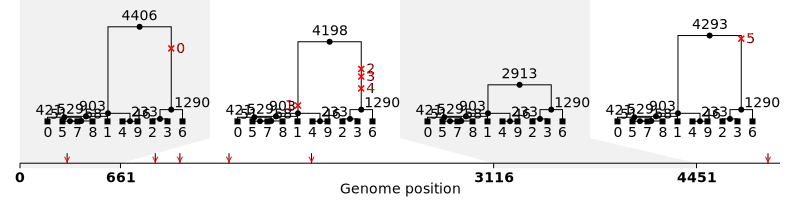

In [6]:
reduced_ts = ts.simplify([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # simplify to the first 10 samples
print("Genealogy of the first 10 samples for the first 5kb of the genome")
reduced_ts.draw_svg(x_lim=(0, 5000))

These are much more standard-looking coalescent trees, with far longer branches higher
up in the tree, and therefore many more mutations at higher-frequencies.

:::{margin}
You cannot directly edit a tree sequence; to add e.g. metadata you must edit a
copy of the underlying tables. This is described in the
{ref}`Tables and editing tutorial<sec_tables_editing>`.
:::

:::{note}
In this tutorial we refer to objects, such as sample nodes, by their numerical IDs. These
can change after simplification, and it is often more meaningful to 
{ref}`work with metadata<sec_tutorial_metadata>`, such as sample and population names,
which can be permanently attached to objects in the tree sequence. Such metadata is
often incorporated automatically by the tools generating the tree sequence. 
:::

(sec_processing_sites_and_mutations)=

## Processing sites and mutations

:::{margin}
See the tutorial entitled "{ref}`sec_tskit_no_mutations`" for why you may not need
sites or mutations in your analyses.
:::

For many purposes it may be better to focus on the genealogy of your samples, rather than
the {ref}`sites<sec_data_model_definitions_site>` and
{ref}`mutations<sec_data_model_definitions_mutation>` that
{ref}`define <sec_what_is_dna_data>` the genome sequence itself. Nevertheless,
{program}`tskit` also provides efficient ways to return {class}`Site` object and
{class}`Mutation` objects from a tree sequence.
For instance, under the finite sites model of mutation that we used above, multiple mutations
can occur at some sites, and we can identify them by iterating over the sites using the
{meth}`TreeSequence.sites` method:

In [7]:
import numpy as np
num_muts = np.zeros(ts.num_sites, dtype=int)
for site in ts.sites():
    num_muts[site.id] = len(site.mutations)  # site.mutations is a list of mutations at the site

# Print out some info about mutations per site
for nmuts, count in enumerate(np.bincount(num_muts)):
    info = f"{count} sites"
    if nmuts > 1:
        info += f", with IDs {np.where(num_muts==nmuts)[0]},"
    print(info, f"have {nmuts} mutation" + ("s" if nmuts != 1 else ""))

0 sites have 0 mutations
13540 sites have 1 mutation
14 sites, with IDs [ 2275  2287  2658  3789  4043  9694 11023 11780 11853 11890 11999 12023
 12096 12310], have 2 mutations


(sec_processing_genotypes)=

## Processing genotypes

At each site, the sample nodes will have a particular allelic state (or be flagged as
{ref}`tskit:sec_data_model_missing_data`). The
{meth}`TreeSequence.variants` method gives access to the
full variation data. For efficiency, the {attr}`~Variant.genotypes`
at a site are returned as a [numpy](https://numpy.org) array of integers:

In [8]:
import numpy as np
np.set_printoptions(linewidth=200)  # print genotypes on a single line

print("Genotypes")
for v in ts.variants():
    print(f"Site {v.site.id}: {v.genotypes}")
    if v.site.id >= 4:  # only print up to site ID 4
        print("...")
        break

Genotypes
Site 0: [0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
Site 1: [1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1]
Site 2: [0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
Site 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Site 4: [0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
...


:::{note}
Tree sequences are optimised to look at all samples at one site, then all samples at an
adjacent site, and so on along the genome. It is much less efficient look at all the
sites for a single sample, then all the sites for the next sample, etc. In other words,
you should generally iterate over sites, not samples. Nevertheless, all the alleles for
a single sample can be obtained via the
{meth}`TreeSequence.haplotypes` method.
:::


To find the actual allelic states at a site, you can refer to the
{attr}`~Variant.alleles` provided for each {class}`Variant`:
the genotype value is an index into this list. Here's one way to print them out; for
clarity this example also prints out the IDs of both the sample nodes (i.e. the genomes)
and the diploid {ref}`individuals <sec_nodes_or_individuals>` in which each sample
node resides.

In [9]:
samp_ids = ts.samples()
print("  ID of diploid individual: ", " ".join([f"{ts.node(s).individual:3}" for s in samp_ids]))
print("       ID of (sample) node: ", " ".join([f"{s:3}" for s in samp_ids]))
for v in ts.variants():
    site = v.site
    alleles = np.array(v.alleles)
    print(f"Site {site.id} (ancestral state '{site.ancestral_state}')",  alleles[v.genotypes])
    if site.id >= 4:  # only print up to site ID 4
        print("...")
        break

  ID of diploid individual:    0   0   1   1   2   2   3   3   4   4   5   5   6   6   7   7   8   8   9   9  10  10  11  11  12  12  13  13  14  14  15  15  16  16  17  17  18  18  19  19
       ID of (sample) node:    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
Site 0 (ancestral state 'G') ['G' 'G' 'T' 'T' 'G' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'T' 'G' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'T' 'G' 'T' 'G' 'G' 'G' 'G' 'G']
Site 1 (ancestral state 'T') ['G' 'G' 'T' 'T' 'G' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'T' 'T' 'G' 'T' 'G' 'G' 'G' 'G' 'G' 'T' 'G' 'T' 'G' 'T' 'T' 'G' 'G']
Site 2 (ancestral state 'T') ['T' 'T' 'C' 'C' 'T' 'T' 'C' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'C' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'C' 'T' 'T' 'C' 'T' 'T' 'T' 'T' 'T' 'C' 'T' 'C' 'T' 'T' 'T' 'T' 'T']
Site 3 (ancestral state 'T') ['T' 'T' 'T' 'T' 'T'

:::{note}
Since we have used the {class}`msprime.JC69` model of mutations, the alleles are all
either 'A', 'T', 'G', or 'C'. However, more complex mutation models can involve mutations
such as indels, leading to allelic states which need not be one of these 4 letters, nor
even be a single letter.
:::


(sec_tskit_getting_started_compute_statistics)=

## Computing statistics

There are a {ref}`large number of statistics<tskit:sec_stats>` and related calculations
built in to {program}`tskit`. Indeed, many basic population genetic statistics are based
on the allele (or site) frequency spectrum (AFS), which can be obtained from a tree sequence
using the {meth}`TreeSequence.allele_frequency_spectrum`
method:

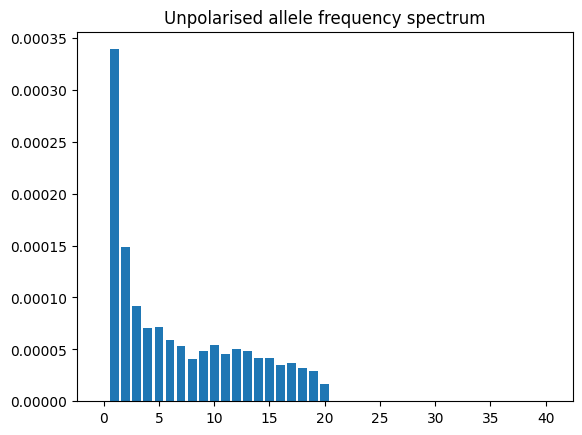

In [10]:
afs = ts.allele_frequency_spectrum()
plt.bar(np.arange(ts.num_samples + 1), afs)
plt.title("Unpolarised allele frequency spectrum")
plt.show()

By default this method returns the "folded" or unpolarized AFS that doesn't
{ref}`take account of the ancestral state<tskit:sec_stats_polarisation>`.
However, since the tree sequence provides the ancestral state, we can plot the polarized
version; additionally we can base our calculations on branch lengths rather than alleles,
which provides an estimate that is not influenced by random mutational "noise".

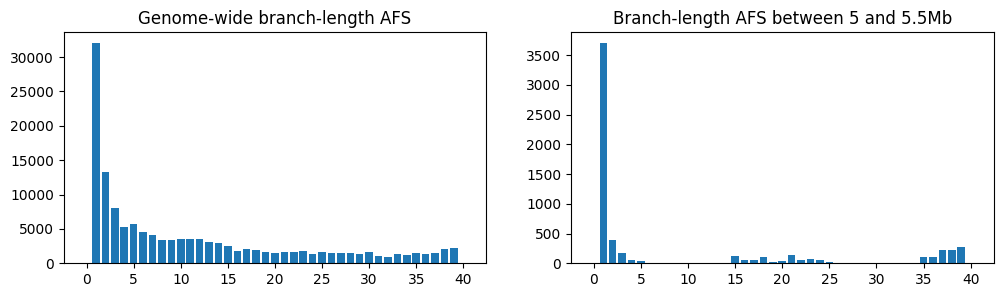

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

afs1 = ts.allele_frequency_spectrum(polarised=True, mode="branch")
ax1.bar(np.arange(ts.num_samples+1), afs1)
ax1.set_title("Genome-wide branch-length AFS")

restricted_ts = ts.keep_intervals([[5e6, 5.5e6]])
afs2 = restricted_ts.allele_frequency_spectrum(polarised=True, mode="branch")
ax2.bar(np.arange(restricted_ts.num_samples+1), afs2)
ax2.set_title("Branch-length AFS between 5 and 5.5Mb")

plt.show()

On the left is the frequency spectrum averaged over the entire genome, and on the right
is the spectrum for a section of the tree sequence between 5 and 5.5Mb, which we've
created by deleting the regions outside that interval using
{meth}`TreeSequence.keep_intervals`. Unsurprisingly,
as we noted when looking at the trees, there's a far higher proportion of singletons in
the region of the sweep.

(sec_tskit_getting_started_compute_statistics_windowing)=

### Windowing

It is often useful to see how statistics vary in different genomic regions. This is done
by calculating them in {ref}`tskit:sec_stats_windows` along the genome. For this,
let's look at a single statistic, the genetic {meth}`~TreeSequence.diversity` (π). As a
site statistic this measures the average number of genetic differences between two
randomly chosen samples, whereas as a branch length statistic it measures the average
branch length between them. We'll plot how the value of π changes using 10kb windows,
plotting the resulting diversity between positions 4 and 6 Mb:

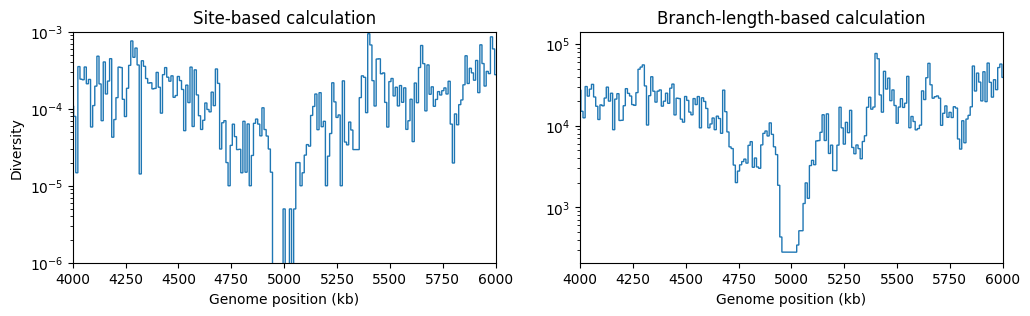

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
L = int(ts.sequence_length)
windows = np.linspace(0, L, num=L//10_000)
ax1.stairs(ts.diversity(windows=windows), windows/1_000, baseline=None)  # Default is mode="site"
ax1.set_ylabel("Diversity")
ax1.set_xlabel("Genome position (kb)")
ax1.set_title("Site-based calculation")
ax1.set_xlim(4e3, 6e3)
ax1.set_yscale("log")
ax1.set_ylim(1e-6, 1e-3)
ax2.stairs(ts.diversity(windows=windows, mode="branch"), windows/1_000, baseline=None)
ax2.set_xlabel("Genome position (kb)")
ax2.set_title("Branch-length-based calculation")
ax2.set_xlim(4e3, 6e3)
ax2.set_yscale("log")
plt.show()

There's a clear drop in diversity in the region of the selective sweep. And as expected,
the statistic based on branch-lengths gives a less noisy signal.


(sec_tskit_getting_started_exporting_data)=

## Saving and exporting data

Tree sequences can be efficiently saved to file using {meth}`TreeSequence.dump`, and
loaded back again using {func}`tskit.load`. By convention, we use the suffix ``.trees``
for such files:

In [13]:
import tskit

ts.dump("data/my_tree_sequence.trees")
new_ts = tskit.load("data/my_tree_sequence.trees")

It's also possible to export tree sequences to different formats. Note, however, that
not only are these usually much larger files, but that analysis is usually much faster
when performed by built-in tskit functions than by exporting and using alternative
software. If you have a large tree sequence, you should *try to avoid exporting
to other formats*.

### Newick and Nexus format

The most common format for interchanging tree data is Newick. 
We can export to a newick format string quite easily. This can be useful for
interoperating with existing tree processing libraries but is very inefficient for
large trees. There is also no support for including sites and mutations in the trees.

In [14]:
small_ts = reduced_ts.keep_intervals([[0, 10000]])
tree = small_ts.first()
print(tree.newick(precision=3))

(((5:135.000,10:135.000):5614.805,(2:3587.236,(1:2945.281,(9:290.004,(6:150.836,8:150.836):139.168):2655.277):641.955):2162.570):61457.489,(7:8362.020,(3:1757.640,4:1757.640):6604.380):58845.274);


For an entire set of trees, you can use the Nexus file format, which acts as a container
for a list of Newick format trees, one per line:

In [15]:
small_ts = small_ts.trim()  # Must trim off the blank region at the end of cut-down ts
print(small_ts.as_nexus(precision=3, include_alignments=False))

#NEXUS
BEGIN TAXA;
  DIMENSIONS NTAX=10;
  TAXLABELS n0 n1 n2 n3 n4 n5 n6 n7 n8 n9;
END;
BEGIN TREES;
  TREE t0.000^661.000 = [&R] (((n4:135.000,n9:135.000):5614.805,(n1:3587.236,(n0:2945.281,(n8:290.004,(n5:150.836,n7:150.836):139.168):2655.277):641.955):2162.570):61457.489,(n6:8362.020,(n2:1757.640,n3:1757.640):6604.380):58845.274);
  TREE t661.000^3116.000 = [&R] (((n4:135.000,n9:135.000):5614.805,(n1:3587.236,(n0:2945.281,(n8:290.004,(n5:150.836,n7:150.836):139.168):2655.277):641.955):2162.570):50834.692,(n6:8362.020,(n2:1757.640,n3:1757.640):6604.380):48222.477);
  TREE t3116.000^4451.000 = [&R] (((n4:135.000,n9:135.000):5614.805,(n1:3587.236,(n0:2945.281,(n8:290.004,(n5:150.836,n7:150.836):139.168):2655.277):641.955):2162.570):20242.950,(n6:8362.020,(n2:1757.640,n3:1757.640):6604.380):17630.736);
  TREE t4451.000^5076.000 = [&R] (((n4:135.000,n9:135.000):5614.805,(n1:3587.236,(n0:2945.281,(n8:290.004,(n5:150.836,n7:150.836):139.168):2655.277):641.955):2162.570):55250.945,(n6:8362

### VCF

The standard way of interchanging genetic variation data is the Variant Call Format, 
for which tskit has basic support:

In [16]:
import sys
small_ts.write_vcf(sys.stdout)

##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2	tsk_3	tsk_4
1	310	0	G	T	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	890	1	T	G	.	PASS	.	GT	1|1	0|0	1|1	0|1	1|1
1	1052	2	T	C	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	1375	3	T	A	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	1918	4	A	G	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	4921	5	T	G	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	5050	6	C	A	.	PASS	.	GT	1|1	0|0	1|1	0|1	1|1
1	5132	7	T	A	.	PASS	.	GT	0|0	0|0	0|1	0|0	0|0
1	5531	8	T	A	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0
1	7204	9	A	T	.	PASS	.	GT	0|0	1|1	0|0	1|0	0|0
1	8930	10	A	G	.	PASS	.	GT	0|0	1|0	0|0	0|0	0|0
1	9800	11	C	G	.	PASS	.	GT	1|1	0|0	1|1	0|1	1|1


The write_vcf method takes a file object as a parameter; to get it to write out to the
notebook here we ask it to write to stdout.

### Scikit-allel

Because tskit integrates very closely with numpy, we can interoperate very efficiently
with downstream Python libraries for working with genetic
sequence data, such as [scikit-allel](https://scikit-allel.readthedocs.io/en/stable/).
We can interoperate with {program}`scikit-allel` by exporting the genotype matrix as a
numpy array, which {program}`scikit-allel` can then process in various ways.

In [17]:
import allel
# Export the genotype data to allel. Unfortunately there's a slight mismatch in the 
# terminology here where genotypes and haplotypes mean different things in the two
# libraries.
h = allel.HaplotypeArray(small_ts.genotype_matrix())
print(h.n_variants, h.n_haplotypes)
h

12 10


<HaplotypeArray shape=(12, 10) dtype=int32>
0 0 1 1 0 0 1 0 0 0
1 1 0 0 1 1 0 1 1 1
0 0 1 1 0 0 1 0 0 0
...
0 0 1 1 0 0 1 0 0 0
0 0 1 0 0 0 0 0 0 0
1 1 0 0 1 1 0 1 1 1

Sckit.allel has a wide-ranging and efficient suite of tools for working with genotype
data, so should provide anything that's needed. For example, it gives us an
another way to compute the pairwise diversity statistic (that we calculated
{ref}`above<sec_tskit_getting_started_compute_statistics_windowing>`
using the native {meth}`TreeSequence.diversity` method):

In [18]:
ac = h.count_alleles()
allel.mean_pairwise_difference(ac)

array([0.46666667, 0.46666667, 0.46666667, 0.46666667, 0.46666667, 0.46666667, 0.46666667, 0.2       , 0.2       , 0.46666667, 0.2       , 0.46666667])

(sec_tskit_getting_started_key_points)=

## Key points covered above

Some simple methods and take-home messages from this introduction to the
{program}`tskit` {ref}`sec_python_api`,
in rough order of importance:

* Objects and their attributes
    * In Python, a {class}`TreeSequence` object has a number of basic attributes such as
        {attr}`~TreeSequence.num_trees`, {attr}`~TreeSequence.num_sites`,
        {attr}`~TreeSequence.num_samples`, {attr}`~TreeSequence.sequence_length`, etc.
        Similarly a {class}`Tree` object has e.g. an {attr}`~Tree.interval` attribute, a
        {class}`Site` object has a {attr}`~Site.mutations` attribute, a {class}`Node`
        object has a {attr}`~Node.time` attribute, and so on.
    * {ref}`sec_terminology_nodes` (i.e. genomes) can belong to
        {ref}`individuals<sec_terminology_individuals_and_populations>`. For example,
        sampling a diploid individual results in an {class}`Individual` object which
        possesses two distinct {ref}`sample nodes<sec_terminology_nodes_samples>`.
* Key tree sequence methods
    * {meth}`~TreeSequence.samples()` returns an array of node IDs specifying the
        nodes that are marked as samples
    * {meth}`~TreeSequence.node` returns the node object for a given integer node ID
    * {meth}`~TreeSequence.trees` iterates over all the trees
    * {meth}`~TreeSequence.sites` iterates over all the sites
    * {meth}`~TreeSequence.variants` iterates over all the sites with their genotypes
        and alleles
    * {meth}`~TreeSequence.simplify()` reduces the number of sample nodes in the tree
        sequence to a specified subset
    * {meth}`~TreeSequence.keep_intervals()` (or its complement,
        {meth}`~TreeSequence.delete_intervals()`) removes genetic information from
        specific regions of the genome
    * {meth}`~TreeSequence.draw_svg()` returns an SVG representation of a tree sequence
        (and plots it if in a Jupyter notebook). Similarly, {meth}`Tree.draw_svg()`
        plots individual trees.
    * {meth}`~TreeSequence.at()` returns a tree at a particular genomic position
        (but using {meth}`~TreeSequence.trees` is usually preferable)
    * Various population genetic statistics can be calculated using methods on a tree
        sequence, for example {meth}`~TreeSequence.allele_frequency_spectrum`,
        {meth}`~TreeSequence.diversity`, and {meth}`~TreeSequence.Fst`; these can
        also be calculated in windows along the genome.